In [1]:
!pip install torchinfo

# Import Libraries

In [2]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
import seaborn as sns

# Configuration

In [3]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


# Variables

In [4]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_dir = "/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer"
output_dir = "/kaggle/working/processed-dataset"  
checkpoints_path = "/kaggle/working/"
os.makedirs(output_dir, exist_ok=True)

train_batch = 32
test_batch = 16
total_class = 3
learning_rate = 0.0001
decay = 1e-4
epoch = 100
patience = 100

# Explore Dataset

In [5]:
def load_split(split_dir):
    file_paths, labels = [], []
    for class_name in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, class_name)
        if os.path.isdir(class_dir):
            for image_name in os.listdir(class_dir):
                file_paths.append(os.path.join(class_dir, image_name))
                labels.append(class_name)
    return pd.DataFrame({"file_path": file_paths, "label": labels})

data = load_split(os.path.join(data_dir, "Brain Cancer"))

In [6]:
train_dataframe, temp_dataframe = train_test_split(
    data, 
    test_size=0.30, 
    stratify=data['label'], 
    random_state=42
)

validation_dataframe, test_dataframe = train_test_split(
    temp_dataframe, 
    test_size=0.50, 
    stratify=temp_dataframe['label'], 
    random_state=42
)

Dataset Split Ratios
Train: 10500 images (70.00%)
Test: 2250 images (15.00%)
Validation: 2250 images (15.00%)


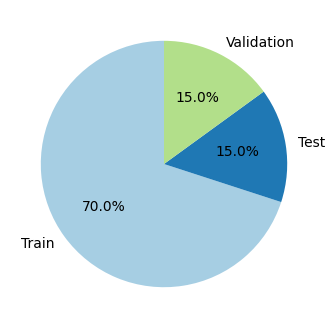

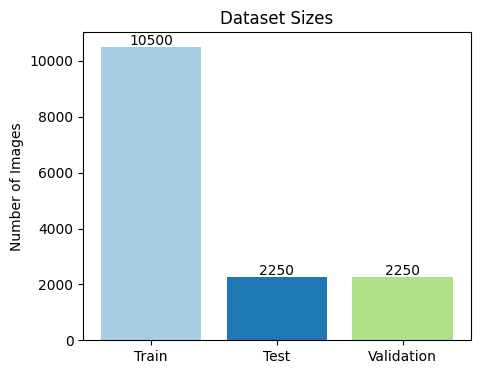

In [7]:
sizes = {
    "Train": len(train_dataframe),
    "Test": len(test_dataframe),
    "Validation": len(validation_dataframe)
}

total = sum(sizes.values())
ratios = {k: (v / total) * 100 for k, v in sizes.items()}

print("Dataset Split Ratios")
for split in sizes.keys():
    print(f"{split}: {sizes[split]} images ({ratios[split]:.2f}%)")

plt.figure(figsize=(4, 4))
plt.pie(
    sizes.values(),
    labels=sizes.keys(),
    autopct="%.1f%%",
    startangle=90,
    colors=["#a6cee3", "#1f78b4", "#b2df8a"]
)
plt.show()

plt.figure(figsize=(5, 4))
plt.bar(sizes.keys(), sizes.values(), color=["#a6cee3", "#1f78b4", "#b2df8a"])
plt.ylabel("Number of Images")
plt.title("Dataset Sizes")
y_max = max(sizes.values()) * 1.05 
plt.ylim(0, y_max)
for i, v in enumerate(sizes.values()):
    plt.text(i, v + total*0.005, str(v), ha='center')  
plt.show()

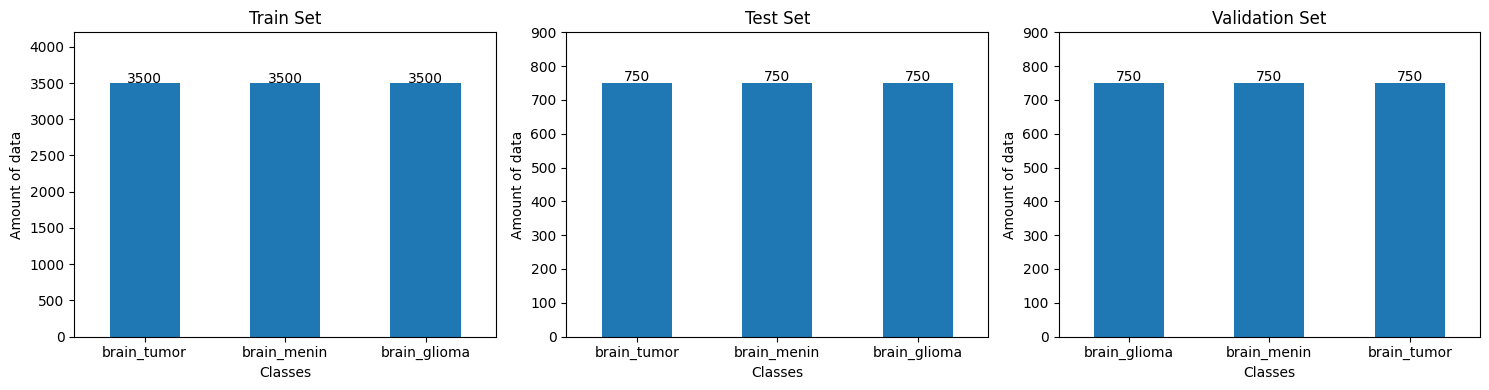

In [ ]:
def class_distribution(train_df, test_df, val_df):
    datasets = {
        "Train": train_df,
        "Test": test_df,
        "Validation": val_df
    }
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for ax, (split_name, df) in zip(axes, datasets.items()):
        class_counts = df['label'].value_counts()

        class_counts.plot(kind='bar', ax=ax)
        ax.set_xlabel('Classes')
        ax.set_ylabel('Amount of data')
        ax.set_title(f'{split_name} Set')
        ax.set_xticks(range(len(class_counts)))
        ax.set_xticklabels(class_counts.index, rotation=360)
        
        for i, count in enumerate(class_counts):
            ax.text(i, count + 5, str(count), ha='center')
        ax.set_ylim(0, max(class_counts) * 1.2)
    
    plt.tight_layout()
    plt.show()

class_distribution(train_dataframe, test_dataframe, validation_dataframe)

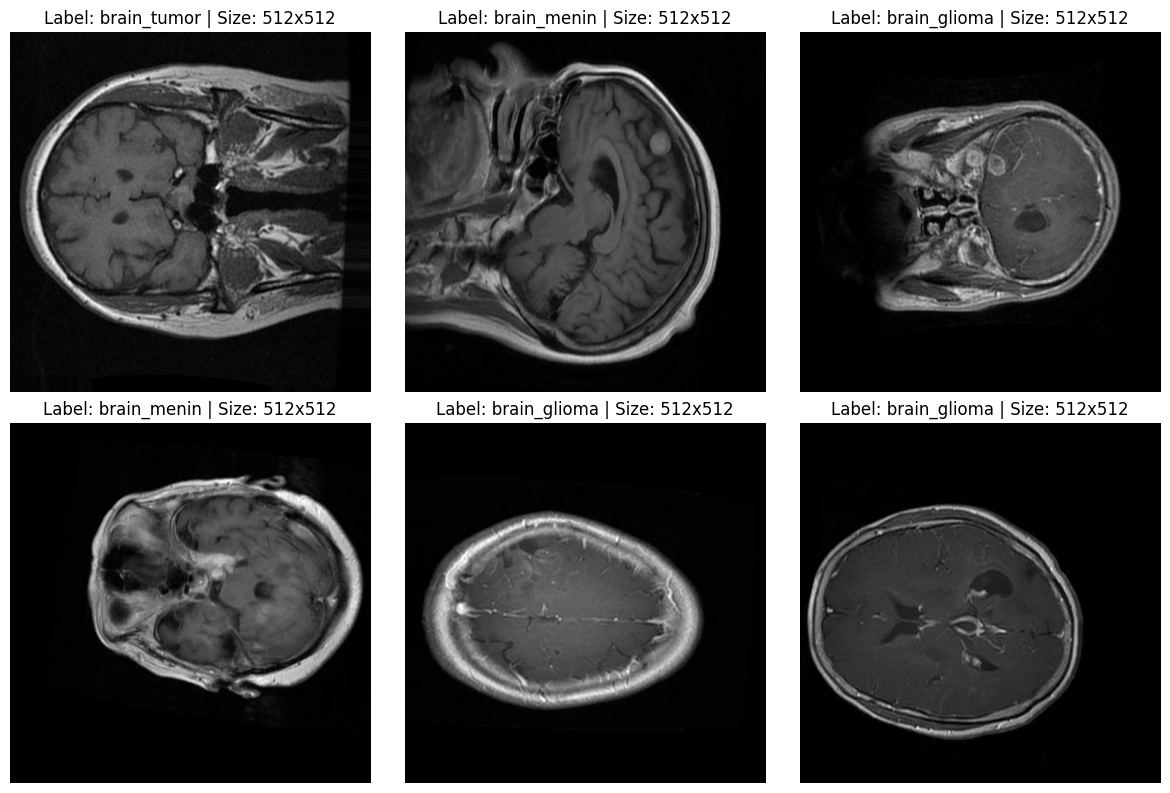

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  
axes = axes.flatten() 

for ax in axes:
    random_index = random.randint(0, len(train_dataframe) - 1)
    random_row = train_dataframe.iloc[random_index]

    file_path = random_row['file_path']
    label = random_row['label']

    image = Image.open(file_path)
    width, height = image.size

    ax.imshow(image)
    ax.set_title(f"Label: {label} | Size: {width}x{height}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Data Preprocessing 

In [10]:
sample_image_path = train_dataframe['file_path'].iloc[0]
img = Image.open(sample_image_path)
num_channels = len(img.getbands())
print(f"Number of channels: {num_channels}")

Number of channels: 3


In [11]:
def data_preprocess(df, split_name, size=(224, 224), quality=100):
    split_dir = os.path.join(output_dir, split_name)
    os.makedirs(split_dir, exist_ok=True)

    processed_file_paths = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {split_name}"):
        label = row['label']
        label_dir = os.path.join(split_dir, label)
        os.makedirs(label_dir, exist_ok=True)

        img = Image.open(row['file_path']).convert("RGB")  
        img = img.resize(size, Image.Resampling.LANCZOS)

        file_name = os.path.basename(row['file_path'])
        save_path = os.path.join(label_dir, file_name)
        img.save(save_path, optimize=True, quality=quality)

        processed_file_paths.append(save_path)

    df['file_path'] = processed_file_paths
    return df

train_dataframe = data_preprocess(train_dataframe, "train")
validation_dataframe = data_preprocess(validation_dataframe, "val")
test_dataframe = data_preprocess(test_dataframe, "test")

Processing test: 100%|██████████| 2250/2250 [00:24<00:00, 92.01it/s]


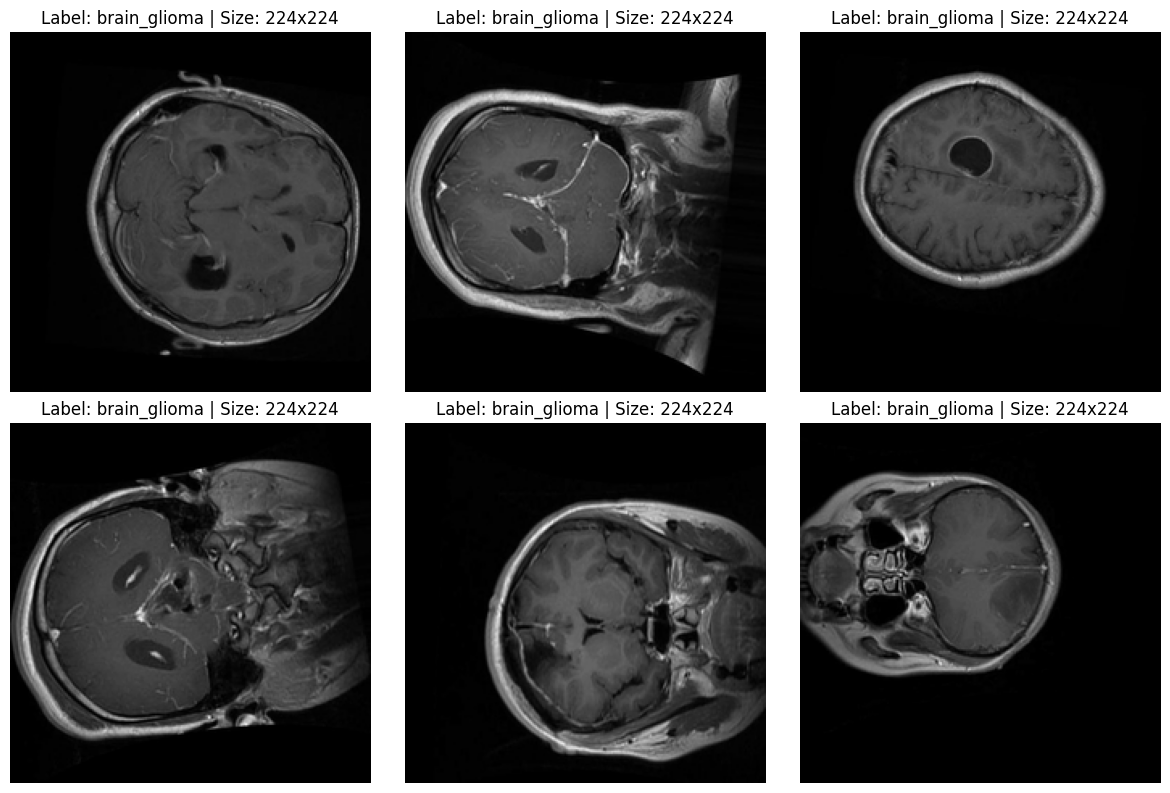

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  
axes = axes.flatten() 

for ax in axes:
    random_index = random.randint(0, len(train_dataframe) - 1)
    random_row = train_dataframe.iloc[random_index]

    file_path = random_row['file_path']
    label = random_row['label']

    image = Image.open(file_path)
    width, height = image.size

    ax.imshow(image)
    ax.set_title(f"Label: {label} | Size: {width}x{height}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Dataset Class, Data Transform and Dataloader

In [13]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        unique_labels = sorted(self.dataframe['label'].unique())
        self.label_map = {label: idx for idx, label in enumerate(unique_labels)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [14]:
def data_transfrom():

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    train_transform = transforms.Compose([
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.GaussianBlur(kernel_size=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    train_dataset = ImageDataset (
        train_dataframe,
        train_transform,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        validation_dataframe,
        transform,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_dataframe,
        transform,
        is_lb=True
    )

    print("Label encoding:")
    for label, idx in train_dataset.label_map.items():
        print(f"{label} -> {idx}")
        
    train_dataloader = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=2)
    validation_dataloader = DataLoader(valid_dataset, batch_size = test_batch, shuffle=False, num_workers=2)
    test_dataloader = DataLoader(test_dataset, batch_size = test_batch, shuffle=False, num_workers=2)

    return train_dataloader, validation_dataloader, test_dataloader

train_dataloader, validation_dataloader, test_dataloader = data_transfrom()

Label encoding:
brain_glioma -> 0
brain_menin -> 1
brain_tumor -> 2


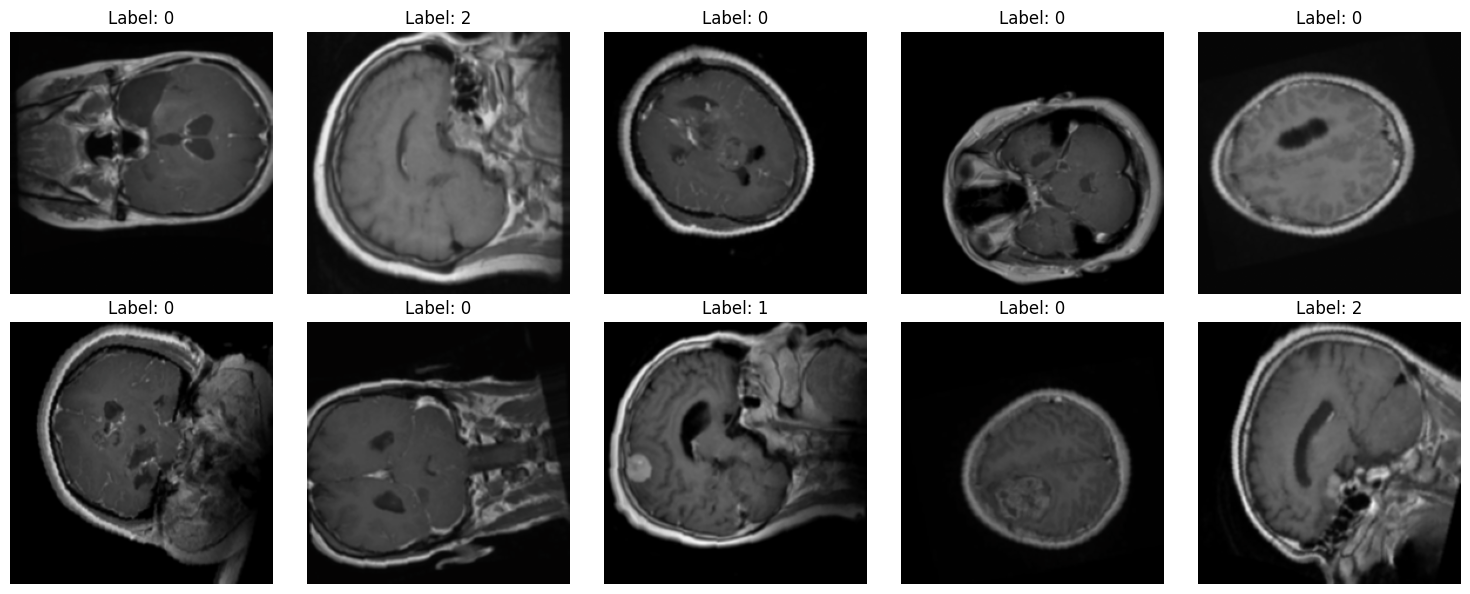

In [15]:
def augmented_samples(dataloader, num_images=10):
    images, labels = next(iter(dataloader))  

    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    images = images * std[None, :, None, None] + mean[None, :, None, None]
    images = torch.clamp(images, 0, 1)  

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, ax in enumerate(axes.flat):
        if i >= num_images:
            break
        img = images[i].permute(1, 2, 0).cpu().numpy() 
        label = labels[i].item()
        ax.imshow(img)
        ax.set_title(f"Label: {label}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

augmented_samples(train_dataloader)

# Deep Learning Model

In [16]:
class BrainCancerNet(nn.Module):
    def __init__(self, num_classes):
        super(BrainCancerNet, self).__init__()
        
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 112x112
            
            # Conv Block 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 56x56
            
            # Conv Block 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 28x28
            
            # Conv Block 4
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 14x14
            
            # Conv Block 5
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 7x7
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [17]:
num_classes = total_class  
model = BrainCancerNet(num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay)
criterion = nn.CrossEntropyLoss()
summary(model, input_size=(train_batch, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
BrainCancerNet                           [32, 3]                   --
├─Sequential: 1-1                        [32, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [32, 32, 224, 224]        896
│    └─BatchNorm2d: 2-2                  [32, 32, 224, 224]        64
│    └─ReLU: 2-3                         [32, 32, 224, 224]        --
│    └─MaxPool2d: 2-4                    [32, 32, 112, 112]        --
│    └─Conv2d: 2-5                       [32, 64, 112, 112]        18,496
│    └─BatchNorm2d: 2-6                  [32, 64, 112, 112]        128
│    └─ReLU: 2-7                         [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-8                    [32, 64, 56, 56]          --
│    └─Conv2d: 2-9                       [32, 128, 56, 56]         73,856
│    └─BatchNorm2d: 2-10                 [32, 128, 56, 56]         256
│    └─ReLU: 2-11                        [32, 128, 56, 56]         --
│   

# Model Training

In [18]:
start_time = time.time()

def train_model(model, criterion, optimizer, train_dataloader, validation_dataloader, num_epochs=epoch, early_stop_patience=patience, checkpoints_path="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in validation_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{checkpoints_path}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1
            print(f"EARLY STOP COUNTER {consecutive_no_improvement} (NO IMPROVEMENT IN VALIDATION ACCURACY)")

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
            print(f"EARLY STOP COUNTER {num_epochs_loss_greater} (VALIDATION LOSS IS HIGHER)")
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, criterion, optimizer, train_dataloader, validation_dataloader, checkpoints_path=checkpoints_path)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_logs.xlsx', index=False)

Epoch 1/100: 100%|██████████| 329/329 [00:43<00:00,  7.65it/s, acc=0.712, loss=0.7]

Training Loss: 0.700 Acc: 0.712


Validation Loss: 0.341 Acc: 0.868
Best model saved at epoch 1 with validation accuracy: 0.868


Epoch 2/100: 100%|██████████| 329/329 [00:43<00:00,  7.59it/s, acc=0.832, loss=0.41]

Training Loss: 0.410 Acc: 0.832


Validation Loss: 0.320 Acc: 0.874
Best model saved at epoch 2 with validation accuracy: 0.874


Epoch 3/100: 100%|██████████| 329/329 [00:43<00:00,  7.64it/s, acc=0.871, loss=0.324]

Training Loss: 0.324 Acc: 0.871


Validation Loss: 0.300 Acc: 0.893
Best model saved at epoch 3 with validation accuracy: 0.893


Epoch 4/100: 100%|██████████| 329/329 [00:43<00:00,  7.52it/s, acc=0.889, loss=0.277]

Training Loss: 0.277 Acc: 0.889


Validation Loss: 0.383 Acc: 0.835
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 5/100: 100%|██████████| 329/329 [00:43<00:00,  7.54it/s, acc=0.903, loss=0.249]

Training Loss: 0.249 Acc: 0.903


Validation Loss: 0.189 Acc: 0.928
Best model saved at epoch 5 with validation accuracy: 0.928


Epoch 6/100: 100%|██████████| 329/329 [00:43<00:00,  7.61it/s, acc=0.908, loss=0.233]

Training Loss: 0.233 Acc: 0.908


Validation Loss: 0.498 Acc: 0.824
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 7/100: 100%|██████████| 329/329 [00:42<00:00,  7.66it/s, acc=0.92, loss=0.204]

Training Loss: 0.204 Acc: 0.920


Validation Loss: 0.312 Acc: 0.890
EARLY STOP COUNTER 2 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 8/100: 100%|██████████| 329/329 [00:43<00:00,  7.50it/s, acc=0.927, loss=0.187]

Training Loss: 0.187 Acc: 0.927


Validation Loss: 0.263 Acc: 0.911
EARLY STOP COUNTER 3 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 3 (VALIDATION LOSS IS HIGHER)


Epoch 9/100: 100%|██████████| 329/329 [00:43<00:00,  7.63it/s, acc=0.934, loss=0.177]

Training Loss: 0.177 Acc: 0.934


Validation Loss: 0.146 Acc: 0.946
Best model saved at epoch 9 with validation accuracy: 0.946


Epoch 10/100: 100%|██████████| 329/329 [00:42<00:00,  7.71it/s, acc=0.942, loss=0.155]

Training Loss: 0.155 Acc: 0.942


Validation Loss: 0.135 Acc: 0.947
Best model saved at epoch 10 with validation accuracy: 0.947


Epoch 11/100: 100%|██████████| 329/329 [00:42<00:00,  7.70it/s, acc=0.941, loss=0.157]

Training Loss: 0.157 Acc: 0.941


Validation Loss: 0.228 Acc: 0.922
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 12/100: 100%|██████████| 329/329 [00:42<00:00,  7.65it/s, acc=0.952, loss=0.133]

Training Loss: 0.133 Acc: 0.952


Validation Loss: 0.351 Acc: 0.876
EARLY STOP COUNTER 2 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 13/100: 100%|██████████| 329/329 [00:43<00:00,  7.54it/s, acc=0.953, loss=0.128]

Training Loss: 0.128 Acc: 0.953


Validation Loss: 0.404 Acc: 0.864
EARLY STOP COUNTER 3 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 3 (VALIDATION LOSS IS HIGHER)


Epoch 14/100: 100%|██████████| 329/329 [00:43<00:00,  7.56it/s, acc=0.956, loss=0.121]

Training Loss: 0.121 Acc: 0.956


Validation Loss: 0.264 Acc: 0.892
EARLY STOP COUNTER 4 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 4 (VALIDATION LOSS IS HIGHER)


Epoch 15/100: 100%|██████████| 329/329 [00:42<00:00,  7.65it/s, acc=0.955, loss=0.116]

Training Loss: 0.116 Acc: 0.955


Validation Loss: 0.081 Acc: 0.969
Best model saved at epoch 15 with validation accuracy: 0.969


Epoch 16/100: 100%|██████████| 329/329 [00:42<00:00,  7.72it/s, acc=0.962, loss=0.106]

Training Loss: 0.106 Acc: 0.962


Validation Loss: 0.081 Acc: 0.969
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 17/100: 100%|██████████| 329/329 [00:43<00:00,  7.60it/s, acc=0.966, loss=0.093]

Training Loss: 0.093 Acc: 0.966


Validation Loss: 0.107 Acc: 0.958
EARLY STOP COUNTER 2 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 18/100: 100%|██████████| 329/329 [00:43<00:00,  7.61it/s, acc=0.966, loss=0.0947]

Training Loss: 0.095 Acc: 0.966


Validation Loss: 0.067 Acc: 0.976
Best model saved at epoch 18 with validation accuracy: 0.976


Epoch 19/100: 100%|██████████| 329/329 [00:43<00:00,  7.61it/s, acc=0.968, loss=0.0924]

Training Loss: 0.092 Acc: 0.968


Validation Loss: 0.110 Acc: 0.959
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 20/100: 100%|██████████| 329/329 [00:43<00:00,  7.48it/s, acc=0.969, loss=0.0871]

Training Loss: 0.087 Acc: 0.969


Validation Loss: 0.274 Acc: 0.904
EARLY STOP COUNTER 2 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 21/100: 100%|██████████| 329/329 [00:43<00:00,  7.52it/s, acc=0.967, loss=0.0833]

Training Loss: 0.083 Acc: 0.967


Validation Loss: 0.112 Acc: 0.961
EARLY STOP COUNTER 3 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 3 (VALIDATION LOSS IS HIGHER)


Epoch 22/100: 100%|██████████| 329/329 [00:43<00:00,  7.53it/s, acc=0.972, loss=0.0775]

Training Loss: 0.077 Acc: 0.972


Validation Loss: 0.067 Acc: 0.977
Best model saved at epoch 22 with validation accuracy: 0.977


Epoch 23/100: 100%|██████████| 329/329 [00:43<00:00,  7.49it/s, acc=0.973, loss=0.0742]

Training Loss: 0.074 Acc: 0.973


Validation Loss: 0.045 Acc: 0.982
Best model saved at epoch 23 with validation accuracy: 0.982


Epoch 24/100: 100%|██████████| 329/329 [00:43<00:00,  7.53it/s, acc=0.974, loss=0.073]

Training Loss: 0.073 Acc: 0.974


Validation Loss: 0.064 Acc: 0.980
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 25/100: 100%|██████████| 329/329 [00:43<00:00,  7.57it/s, acc=0.976, loss=0.0699]

Training Loss: 0.070 Acc: 0.976


Validation Loss: 0.063 Acc: 0.976
EARLY STOP COUNTER 2 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 26/100: 100%|██████████| 329/329 [00:44<00:00,  7.42it/s, acc=0.976, loss=0.0647]

Training Loss: 0.065 Acc: 0.976


Validation Loss: 0.082 Acc: 0.969
EARLY STOP COUNTER 3 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 27/100: 100%|██████████| 329/329 [00:43<00:00,  7.50it/s, acc=0.976, loss=0.0595]

Training Loss: 0.060 Acc: 0.976


Validation Loss: 0.076 Acc: 0.972
EARLY STOP COUNTER 4 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 28/100: 100%|██████████| 329/329 [00:43<00:00,  7.53it/s, acc=0.974, loss=0.0696]

Training Loss: 0.070 Acc: 0.974


Validation Loss: 0.041 Acc: 0.988
Best model saved at epoch 28 with validation accuracy: 0.988


Epoch 29/100: 100%|██████████| 329/329 [00:45<00:00,  7.19it/s, acc=0.978, loss=0.0619]

Training Loss: 0.062 Acc: 0.978


Validation Loss: 0.079 Acc: 0.972
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 30/100: 100%|██████████| 329/329 [00:45<00:00,  7.25it/s, acc=0.977, loss=0.0629]

Training Loss: 0.063 Acc: 0.977


Validation Loss: 0.047 Acc: 0.983
EARLY STOP COUNTER 2 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 31/100: 100%|██████████| 329/329 [00:43<00:00,  7.54it/s, acc=0.98, loss=0.0558]

Training Loss: 0.056 Acc: 0.980


Validation Loss: 0.053 Acc: 0.983
EARLY STOP COUNTER 3 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 32/100: 100%|██████████| 329/329 [00:43<00:00,  7.57it/s, acc=0.982, loss=0.049]

Training Loss: 0.049 Acc: 0.982


Validation Loss: 0.037 Acc: 0.987
EARLY STOP COUNTER 4 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 33/100: 100%|██████████| 329/329 [00:43<00:00,  7.48it/s, acc=0.98, loss=0.0568]

Training Loss: 0.057 Acc: 0.980


Validation Loss: 0.149 Acc: 0.948
EARLY STOP COUNTER 5 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 34/100: 100%|██████████| 329/329 [00:43<00:00,  7.54it/s, acc=0.981, loss=0.0557]

Training Loss: 0.056 Acc: 0.981


Validation Loss: 0.031 Acc: 0.987
EARLY STOP COUNTER 6 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 35/100: 100%|██████████| 329/329 [00:43<00:00,  7.52it/s, acc=0.982, loss=0.0535]

Training Loss: 0.053 Acc: 0.982


Validation Loss: 0.027 Acc: 0.991
Best model saved at epoch 35 with validation accuracy: 0.991


Epoch 36/100: 100%|██████████| 329/329 [00:43<00:00,  7.50it/s, acc=0.985, loss=0.045]

Training Loss: 0.045 Acc: 0.985


Validation Loss: 0.028 Acc: 0.992
Best model saved at epoch 36 with validation accuracy: 0.992


Epoch 37/100: 100%|██████████| 329/329 [00:43<00:00,  7.57it/s, acc=0.982, loss=0.0473]

Training Loss: 0.047 Acc: 0.982


Validation Loss: 0.051 Acc: 0.984
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 38/100: 100%|██████████| 329/329 [00:44<00:00,  7.48it/s, acc=0.986, loss=0.0425]

Training Loss: 0.043 Acc: 0.986


Validation Loss: 0.021 Acc: 0.993
Best model saved at epoch 38 with validation accuracy: 0.993


Epoch 39/100: 100%|██████████| 329/329 [00:44<00:00,  7.35it/s, acc=0.984, loss=0.046]

Training Loss: 0.046 Acc: 0.984


Validation Loss: 0.071 Acc: 0.974
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 40/100: 100%|██████████| 329/329 [00:44<00:00,  7.44it/s, acc=0.981, loss=0.055]

Training Loss: 0.055 Acc: 0.981


Validation Loss: 0.022 Acc: 0.992
EARLY STOP COUNTER 2 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 41/100: 100%|██████████| 329/329 [00:44<00:00,  7.33it/s, acc=0.986, loss=0.0402]

Training Loss: 0.040 Acc: 0.986


Validation Loss: 0.153 Acc: 0.958
EARLY STOP COUNTER 3 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 42/100: 100%|██████████| 329/329 [00:43<00:00,  7.61it/s, acc=0.986, loss=0.0429]

Training Loss: 0.043 Acc: 0.986


Validation Loss: 0.091 Acc: 0.966
EARLY STOP COUNTER 4 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 43/100: 100%|██████████| 329/329 [00:43<00:00,  7.60it/s, acc=0.983, loss=0.0517]

Training Loss: 0.052 Acc: 0.983


Validation Loss: 0.105 Acc: 0.969
EARLY STOP COUNTER 5 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 3 (VALIDATION LOSS IS HIGHER)


Epoch 44/100: 100%|██████████| 329/329 [00:44<00:00,  7.46it/s, acc=0.984, loss=0.048]

Training Loss: 0.048 Acc: 0.984


Validation Loss: 0.053 Acc: 0.978
EARLY STOP COUNTER 6 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 4 (VALIDATION LOSS IS HIGHER)


Epoch 45/100: 100%|██████████| 329/329 [00:43<00:00,  7.53it/s, acc=0.988, loss=0.0347]

Training Loss: 0.035 Acc: 0.988


Validation Loss: 0.091 Acc: 0.970
EARLY STOP COUNTER 7 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 5 (VALIDATION LOSS IS HIGHER)


Epoch 46/100: 100%|██████████| 329/329 [00:45<00:00,  7.29it/s, acc=0.982, loss=0.0439]

Training Loss: 0.044 Acc: 0.982


Validation Loss: 0.060 Acc: 0.978
EARLY STOP COUNTER 8 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 6 (VALIDATION LOSS IS HIGHER)


Epoch 47/100: 100%|██████████| 329/329 [00:44<00:00,  7.41it/s, acc=0.987, loss=0.0389]

Training Loss: 0.039 Acc: 0.987


Validation Loss: 0.290 Acc: 0.905
EARLY STOP COUNTER 9 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 7 (VALIDATION LOSS IS HIGHER)


Epoch 48/100: 100%|██████████| 329/329 [00:44<00:00,  7.34it/s, acc=0.983, loss=0.0472]

Training Loss: 0.047 Acc: 0.983


Validation Loss: 0.030 Acc: 0.990
EARLY STOP COUNTER 10 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 49/100: 100%|██████████| 329/329 [00:44<00:00,  7.46it/s, acc=0.986, loss=0.0382]

Training Loss: 0.038 Acc: 0.986


Validation Loss: 0.035 Acc: 0.986
EARLY STOP COUNTER 11 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 50/100: 100%|██████████| 329/329 [00:43<00:00,  7.54it/s, acc=0.982, loss=0.0498]

Training Loss: 0.050 Acc: 0.982


Validation Loss: 0.024 Acc: 0.994
Best model saved at epoch 50 with validation accuracy: 0.994


Epoch 51/100: 100%|██████████| 329/329 [00:44<00:00,  7.38it/s, acc=0.989, loss=0.0335]

Training Loss: 0.034 Acc: 0.989


Validation Loss: 0.077 Acc: 0.974
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 52/100: 100%|██████████| 329/329 [00:44<00:00,  7.39it/s, acc=0.987, loss=0.0359]

Training Loss: 0.036 Acc: 0.987


Validation Loss: 0.072 Acc: 0.979
EARLY STOP COUNTER 2 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 53/100: 100%|██████████| 329/329 [00:45<00:00,  7.29it/s, acc=0.982, loss=0.0489]

Training Loss: 0.049 Acc: 0.982


Validation Loss: 0.034 Acc: 0.988
EARLY STOP COUNTER 3 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 54/100: 100%|██████████| 329/329 [00:44<00:00,  7.34it/s, acc=0.988, loss=0.0352]

Training Loss: 0.035 Acc: 0.988


Validation Loss: 0.025 Acc: 0.992
EARLY STOP COUNTER 4 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 55/100: 100%|██████████| 329/329 [00:44<00:00,  7.37it/s, acc=0.988, loss=0.0333]

Training Loss: 0.033 Acc: 0.988


Validation Loss: 0.010 Acc: 0.996
Best model saved at epoch 55 with validation accuracy: 0.996


Epoch 56/100: 100%|██████████| 329/329 [00:45<00:00,  7.26it/s, acc=0.987, loss=0.0363]

Training Loss: 0.036 Acc: 0.987


Validation Loss: 0.661 Acc: 0.867
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 57/100: 100%|██████████| 329/329 [00:44<00:00,  7.35it/s, acc=0.988, loss=0.035]

Training Loss: 0.035 Acc: 0.988


Validation Loss: 0.050 Acc: 0.982
EARLY STOP COUNTER 2 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 58/100: 100%|██████████| 329/329 [00:45<00:00,  7.20it/s, acc=0.989, loss=0.0298]

Training Loss: 0.030 Acc: 0.989


Validation Loss: 0.026 Acc: 0.992
EARLY STOP COUNTER 3 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 59/100: 100%|██████████| 329/329 [00:44<00:00,  7.42it/s, acc=0.99, loss=0.032]

Training Loss: 0.032 Acc: 0.990


Validation Loss: 0.041 Acc: 0.987
EARLY STOP COUNTER 4 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 60/100: 100%|██████████| 329/329 [00:45<00:00,  7.18it/s, acc=0.991, loss=0.0296]

Training Loss: 0.030 Acc: 0.991


Validation Loss: 0.067 Acc: 0.978
EARLY STOP COUNTER 5 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 61/100: 100%|██████████| 329/329 [00:44<00:00,  7.47it/s, acc=0.989, loss=0.0317]

Training Loss: 0.032 Acc: 0.989


Validation Loss: 0.009 Acc: 0.996
EARLY STOP COUNTER 6 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 62/100: 100%|██████████| 329/329 [00:44<00:00,  7.34it/s, acc=0.989, loss=0.0329]

Training Loss: 0.033 Acc: 0.989


Validation Loss: 0.012 Acc: 0.995
EARLY STOP COUNTER 7 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 63/100: 100%|██████████| 329/329 [00:45<00:00,  7.26it/s, acc=0.988, loss=0.0327]

Training Loss: 0.033 Acc: 0.988


Validation Loss: 0.009 Acc: 0.997
Best model saved at epoch 63 with validation accuracy: 0.997


Epoch 64/100: 100%|██████████| 329/329 [00:45<00:00,  7.23it/s, acc=0.986, loss=0.0397]

Training Loss: 0.040 Acc: 0.986


Validation Loss: 0.073 Acc: 0.977
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 65/100: 100%|██████████| 329/329 [00:45<00:00,  7.18it/s, acc=0.99, loss=0.0264]

Training Loss: 0.026 Acc: 0.990


Validation Loss: 0.094 Acc: 0.974
EARLY STOP COUNTER 2 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 66/100: 100%|██████████| 329/329 [00:45<00:00,  7.23it/s, acc=0.988, loss=0.0347]

Training Loss: 0.035 Acc: 0.988


Validation Loss: 0.032 Acc: 0.988
EARLY STOP COUNTER 3 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 67/100: 100%|██████████| 329/329 [00:45<00:00,  7.28it/s, acc=0.991, loss=0.0273]

Training Loss: 0.027 Acc: 0.991


Validation Loss: 0.012 Acc: 0.996
EARLY STOP COUNTER 4 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 68/100: 100%|██████████| 329/329 [00:45<00:00,  7.23it/s, acc=0.991, loss=0.0238]

Training Loss: 0.024 Acc: 0.991


Validation Loss: 0.012 Acc: 0.995
EARLY STOP COUNTER 5 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 69/100: 100%|██████████| 329/329 [00:46<00:00,  7.08it/s, acc=0.99, loss=0.0292]

Training Loss: 0.029 Acc: 0.990


Validation Loss: 0.021 Acc: 0.991
EARLY STOP COUNTER 6 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 70/100: 100%|██████████| 329/329 [00:48<00:00,  6.72it/s, acc=0.99, loss=0.0307]

Training Loss: 0.031 Acc: 0.990


Validation Loss: 0.027 Acc: 0.990
EARLY STOP COUNTER 7 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 71/100: 100%|██████████| 329/329 [00:47<00:00,  6.89it/s, acc=0.992, loss=0.0238]

Training Loss: 0.024 Acc: 0.992


Validation Loss: 0.051 Acc: 0.986
EARLY STOP COUNTER 8 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 72/100: 100%|██████████| 329/329 [00:45<00:00,  7.30it/s, acc=0.99, loss=0.0304]

Training Loss: 0.030 Acc: 0.990


Validation Loss: 0.010 Acc: 0.997
EARLY STOP COUNTER 9 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 73/100: 100%|██████████| 329/329 [00:44<00:00,  7.43it/s, acc=0.992, loss=0.0252]

Training Loss: 0.025 Acc: 0.992


Validation Loss: 0.035 Acc: 0.989
EARLY STOP COUNTER 10 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 74/100: 100%|██████████| 329/329 [00:46<00:00,  7.10it/s, acc=0.99, loss=0.0273]

Training Loss: 0.027 Acc: 0.990


Validation Loss: 0.020 Acc: 0.992
EARLY STOP COUNTER 11 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 75/100: 100%|██████████| 329/329 [00:46<00:00,  7.07it/s, acc=0.99, loss=0.0315]

Training Loss: 0.032 Acc: 0.990


Validation Loss: 0.018 Acc: 0.994
EARLY STOP COUNTER 12 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 76/100: 100%|██████████| 329/329 [00:47<00:00,  6.97it/s, acc=0.991, loss=0.0243]

Training Loss: 0.024 Acc: 0.991


Validation Loss: 0.011 Acc: 0.995
EARLY STOP COUNTER 13 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 77/100: 100%|██████████| 329/329 [00:46<00:00,  7.12it/s, acc=0.992, loss=0.0257]

Training Loss: 0.026 Acc: 0.992


Validation Loss: 0.076 Acc: 0.980
EARLY STOP COUNTER 14 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 78/100: 100%|██████████| 329/329 [00:45<00:00,  7.18it/s, acc=0.991, loss=0.0255]

Training Loss: 0.026 Acc: 0.991


Validation Loss: 0.022 Acc: 0.993
EARLY STOP COUNTER 15 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 79/100: 100%|██████████| 329/329 [00:46<00:00,  7.13it/s, acc=0.99, loss=0.0286]

Training Loss: 0.029 Acc: 0.990


Validation Loss: 0.022 Acc: 0.993
EARLY STOP COUNTER 16 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 80/100: 100%|██████████| 329/329 [00:45<00:00,  7.23it/s, acc=0.992, loss=0.0208]

Training Loss: 0.021 Acc: 0.992


Validation Loss: 0.020 Acc: 0.995
EARLY STOP COUNTER 17 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 81/100: 100%|██████████| 329/329 [00:46<00:00,  7.10it/s, acc=0.991, loss=0.0322]

Training Loss: 0.032 Acc: 0.991


Validation Loss: 0.075 Acc: 0.975
EARLY STOP COUNTER 18 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 82/100: 100%|██████████| 329/329 [00:44<00:00,  7.37it/s, acc=0.991, loss=0.0246]

Training Loss: 0.025 Acc: 0.991


Validation Loss: 0.053 Acc: 0.985
EARLY STOP COUNTER 19 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 83/100: 100%|██████████| 329/329 [00:45<00:00,  7.23it/s, acc=0.993, loss=0.0215]

Training Loss: 0.022 Acc: 0.993


Validation Loss: 0.096 Acc: 0.976
EARLY STOP COUNTER 20 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 3 (VALIDATION LOSS IS HIGHER)


Epoch 84/100: 100%|██████████| 329/329 [00:44<00:00,  7.36it/s, acc=0.991, loss=0.0252]

Training Loss: 0.025 Acc: 0.991


Validation Loss: 0.026 Acc: 0.991
EARLY STOP COUNTER 21 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 4 (VALIDATION LOSS IS HIGHER)


Epoch 85/100: 100%|██████████| 329/329 [00:45<00:00,  7.16it/s, acc=0.99, loss=0.0245]

Training Loss: 0.025 Acc: 0.990


Validation Loss: 0.085 Acc: 0.975
EARLY STOP COUNTER 22 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 5 (VALIDATION LOSS IS HIGHER)


Epoch 86/100: 100%|██████████| 329/329 [00:46<00:00,  7.08it/s, acc=0.993, loss=0.0211]

Training Loss: 0.021 Acc: 0.993


Validation Loss: 0.012 Acc: 0.996
EARLY STOP COUNTER 23 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 87/100: 100%|██████████| 329/329 [00:45<00:00,  7.17it/s, acc=0.992, loss=0.0281]

Training Loss: 0.028 Acc: 0.992


Validation Loss: 0.025 Acc: 0.992
EARLY STOP COUNTER 24 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 88/100: 100%|██████████| 329/329 [00:45<00:00,  7.17it/s, acc=0.992, loss=0.0262]

Training Loss: 0.026 Acc: 0.992


Validation Loss: 0.025 Acc: 0.992
EARLY STOP COUNTER 25 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 89/100: 100%|██████████| 329/329 [00:46<00:00,  7.14it/s, acc=0.993, loss=0.0201]

Training Loss: 0.020 Acc: 0.993


Validation Loss: 0.008 Acc: 0.998
Best model saved at epoch 89 with validation accuracy: 0.998


Epoch 90/100: 100%|██████████| 329/329 [00:46<00:00,  7.14it/s, acc=0.992, loss=0.0219]

Training Loss: 0.022 Acc: 0.992


Validation Loss: 0.009 Acc: 0.998
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 91/100: 100%|██████████| 329/329 [00:45<00:00,  7.27it/s, acc=0.99, loss=0.0283]

Training Loss: 0.028 Acc: 0.990


Validation Loss: 0.007 Acc: 0.997
EARLY STOP COUNTER 2 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 92/100: 100%|██████████| 329/329 [00:44<00:00,  7.35it/s, acc=0.993, loss=0.0235]

Training Loss: 0.024 Acc: 0.993


Validation Loss: 0.171 Acc: 0.950
EARLY STOP COUNTER 3 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 93/100: 100%|██████████| 329/329 [00:44<00:00,  7.43it/s, acc=0.988, loss=0.0333]

Training Loss: 0.033 Acc: 0.988


Validation Loss: 0.014 Acc: 0.996
EARLY STOP COUNTER 4 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 94/100: 100%|██████████| 329/329 [00:45<00:00,  7.30it/s, acc=0.993, loss=0.0202]

Training Loss: 0.020 Acc: 0.993


Validation Loss: 0.007 Acc: 0.998
Best model saved at epoch 94 with validation accuracy: 0.998


Epoch 95/100: 100%|██████████| 329/329 [00:44<00:00,  7.47it/s, acc=0.991, loss=0.0262]

Training Loss: 0.026 Acc: 0.991


Validation Loss: 0.012 Acc: 0.995
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 96/100: 100%|██████████| 329/329 [00:44<00:00,  7.46it/s, acc=0.994, loss=0.0199]

Training Loss: 0.020 Acc: 0.994


Validation Loss: 0.016 Acc: 0.994
EARLY STOP COUNTER 2 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 97/100: 100%|██████████| 329/329 [00:45<00:00,  7.29it/s, acc=0.995, loss=0.0125]

Training Loss: 0.013 Acc: 0.995


Validation Loss: 0.006 Acc: 0.998
EARLY STOP COUNTER 3 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 98/100: 100%|██████████| 329/329 [00:44<00:00,  7.38it/s, acc=0.992, loss=0.0202]

Training Loss: 0.020 Acc: 0.992


Validation Loss: 0.402 Acc: 0.903
EARLY STOP COUNTER 4 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 99/100: 100%|██████████| 329/329 [00:44<00:00,  7.42it/s, acc=0.991, loss=0.0245]

Training Loss: 0.024 Acc: 0.991


Validation Loss: 0.091 Acc: 0.970
EARLY STOP COUNTER 5 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 100/100: 100%|██████████| 329/329 [00:45<00:00,  7.22it/s, acc=0.994, loss=0.0181]

Training Loss: 0.018 Acc: 0.994


Validation Loss: 0.008 Acc: 0.998
EARLY STOP COUNTER 6 (NO IMPROVEMENT IN VALIDATION ACCURACY)
Training Time: 4786.71 seconds ---> 79.78 minutes


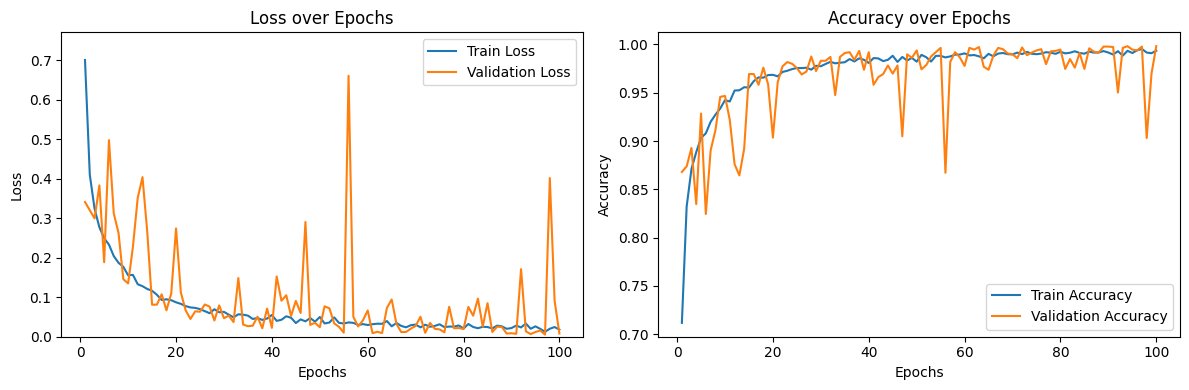

In [19]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend(loc='upper right')
plt.ylim(0, max(max(train_loss_history), max(val_loss_history)) * 1.1)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Load Saved Checkpoints

In [20]:
best_checkpoint_path = f"{checkpoints_path}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

# Evaluation

In [21]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [22]:
start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, test_dataloader)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.995
Test Time: 3.07 seconds ---> 0.05 minutes


In [23]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, test_dataloader, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       750
           1       0.99      1.00      0.99       750
           2       1.00      0.99      0.99       750

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00      1.00      1.00      2250

Class 0 Accuracy: 0.995
Class 1 Accuracy: 0.999
Class 2 Accuracy: 0.992


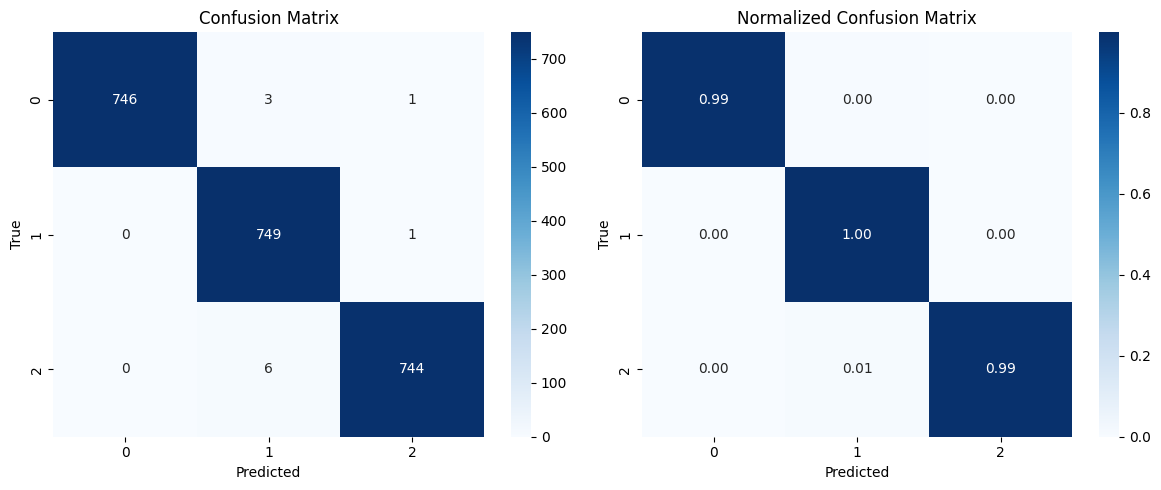

In [24]:
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')

plt.tight_layout()
plt.show()

# Explainable AI (GradCAM)

In [25]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        forward_handle = self.target_layer.register_forward_hook(forward_hook)
        backward_handle = self.target_layer.register_backward_hook(backward_hook)

        self.hook_handles.append(forward_handle)
        self.hook_handles.append(backward_handle)

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    def generate_cam(self, input_tensor, target_class):
        self.model.eval()
        input_tensor.requires_grad_()  
    
        output = self.model(input_tensor)
        self.model.zero_grad()
    
        class_score = output[:, target_class]
        class_score.backward()
    
        gradients = self.gradients  
        activations = self.activations  
    
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)  
    
        cam = torch.sum(weights * activations, dim=1) 
        cam = F.relu(cam)  
        cam = cam.squeeze().cpu().numpy()
        cam -= np.min(cam)
        cam /= (np.max(cam) + 1e-8)
        cam = np.power(cam, 0.5)  
        cam = cv2.resize(cam, (224, 224))
    
        return cam

In [26]:
def denormalize_image(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def show_gradcam(model, dataloader, device, target_layer, classes, num_samples=10,
                 mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225],
                 start_index=0):

    gradcam = GradCAM(model, target_layer)
    all_inputs = []
    all_labels = []

    for inputs, labels in dataloader:
        for i in range(inputs.size(0)):
            all_inputs.append(inputs[i])
            all_labels.append(labels[i])
        if len(all_inputs) >= start_index + num_samples:
            break

    if len(all_inputs) < start_index + num_samples:
        print("Not enough samples in the dataloader.")
        return

    plt.figure(figsize=(8, num_samples * 3))

    for idx in range(start_index, start_index + num_samples):
        input_tensor = all_inputs[idx].unsqueeze(0).to(device)
        label = all_labels[idx].to(device).item()
        output = model(input_tensor)
        pred_class = output.argmax(dim=1).item()

        cam = gradcam.generate_cam(input_tensor, pred_class)

        input_denorm = denormalize_image(all_inputs[idx].clone().cpu(), mean, std)
        img_np = input_denorm.numpy().transpose(1, 2, 0)
        img_np = np.clip(img_np, 0, 1)
        img_uint8 = np.uint8(255 * img_np)

        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        overlay = cv2.addWeighted(heatmap, 0.4, img_uint8, 0.6, 0)

        plt.subplot(num_samples, 2, 2 * (idx - start_index) + 1)
        plt.imshow(img_uint8)
        plt.title(f"Original\nLabel: {classes[label]}")
        plt.axis('off')

        plt.subplot(num_samples, 2, 2 * (idx - start_index) + 2)
        plt.imshow(overlay[..., ::-1])  
        plt.title(f"Grad-CAM\nPredicted Label: {classes[pred_class]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    gradcam.remove_hooks()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


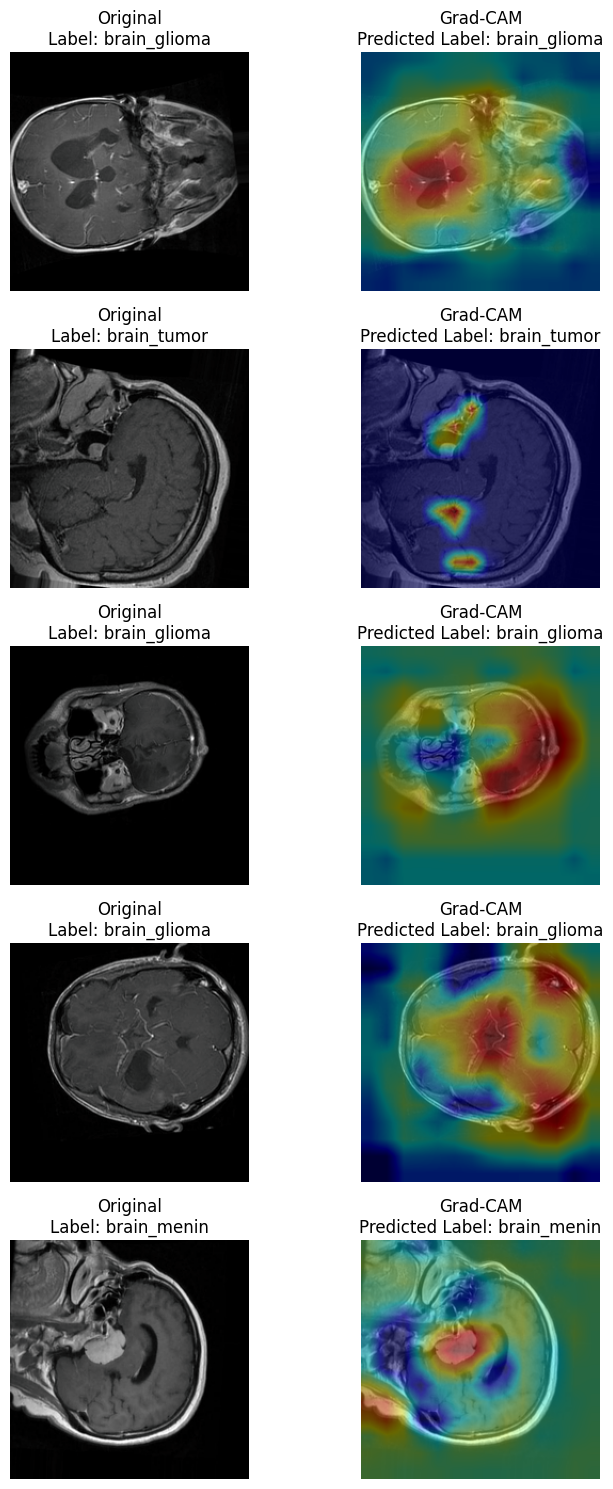

In [27]:
show_gradcam(
    model=model,
    dataloader=validation_dataloader,
    device=device,
    target_layer=model.features[16],
    classes=sorted(train_dataframe['label'].unique()),  
    num_samples=5,
    start_index=100  
)